# ***✅ Part 1: Preparation***



**import libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import KBinsDiscretizer

# Regression data

In [ ]:
data = pd.read_csv('data_final_with_outlier.csv')
print("data shape :",data.shape)
# Show the first few rows to understand the structure
print(data.head())

data shape : (1994, 48)
      state    county  community        communityname  fold  racepctblack  \
0  0.127273  0.002384   0.009838         Lakewoodcity   0.0          0.02   
1  0.945455  0.002384   0.009838          Tukwilacity   0.0          0.12   
2  0.418182  0.002384   0.009838         Aberdeentown   0.0          0.49   
3  0.600000  0.004768   0.860812  Willingborotownship   0.0          1.00   
4  0.745455  0.112038   0.063749    Bethlehemtownship   0.0          0.02   

   racePctWhite  racePctAsian  pctUrban  pctWFarmSelf  ...  NumStreet  \
0          0.90          0.12       1.0          0.34  ...        0.0   
1          0.74          0.45       1.0          0.11  ...        0.0   
2          0.56          0.17       0.0          0.19  ...        0.0   
3          0.08          0.12       1.0          0.21  ...        0.0   
4          0.95          0.09       0.9          0.16  ...        0.0   

   PctBornSameState  PctSameHouse85  PctSameCity85  PctSameState85  LandAr

In [ ]:
X2 = data.drop(columns=['ViolentCrimesPerPop'])
y2 = data['ViolentCrimesPerPop']  # The target variable
X2_encoded = pd.get_dummies(X2)

In [ ]:
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_encoded, y2, test_size=0.2, random_state=42)

print(X2_train.shape, X2_val.shape, y2_train.shape, y2_val.shape)

(1595, 1874) (399, 1874) (1595,) (399,)


# 🔷 Regression with KNN


KNN is distance-based, so all features must be on the same scale.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X2_encoded)
X2_train, X2_val, y2_train, y2_val = train_test_split(X_scaled, y2, test_size=0.2, random_state=42)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the parameter grid for tuning
param_grid = {
    'n_neighbors': [2,3,4, 5,6, 7,8, 9,10, 11],  # Number of neighbors
    'metric': ['euclidean', 'manhattan', 'chebyshev'],  # Distance metrics
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
}

# Create a KNN Regressor model
knn_reg = KNeighborsRegressor()

# Set up the GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=knn_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search
grid_search.fit(X2_train, y2_train)

# Print the best parameters and best score (cross-validated performance)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score (neg_mean_squared_error): {grid_search.best_score_}")

# Use the best model from GridSearchCV to make predictions on validation data
best_knn = grid_search.best_estimator_
y2_pred_val = best_knn.predict(X2_val)

# Evaluate the model performance
mse_val = mean_squared_error(y2_val, y2_pred_val)
r2_val = r2_score(y2_val, y2_pred_val)

print(f"Validation Mean Squared Error: {mse_val}")
print(f"Validation R-squared: {r2_val}")


Best parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Best cross-validation score (neg_mean_squared_error): -0.028090142033360428
Validation Mean Squared Error: 0.023786048454469508
Validation R-squared: 0.5033786922442537


-> the best k is 9

In [ ]:
# Use the best parameters you found
best_knn = KNeighborsRegressor(
    n_neighbors=9,
    weights='distance',
    metric='manhattan'
)

# Fit the model
best_knn.fit(X2_train, y2_train)

# Predict on validation set
y_pred_val = best_knn.predict(X2_val)


In [ ]:
mse = mean_squared_error(y2_val, y2_pred_val)
r2 = r2_score(y2_val, y2_pred_val)

print("Validation Mean Squared Error:", mse)
print("Validation R-squared:", r2)


Validation Mean Squared Error: 0.023786048454469508
Validation R-squared: 0.5033786922442537


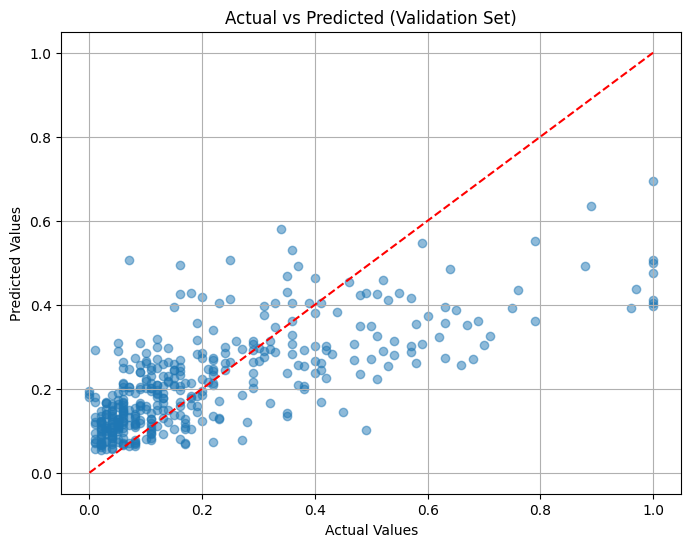

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y2_val, y_pred_val, alpha=0.5)
plt.plot([y2_val.min(), y2_val.max()], [y2_val.min(), y2_val.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted (Validation Set)")
plt.grid(True)
plt.show()


# 🔷 Naïve Bayes for Regression

some vizualization of our data

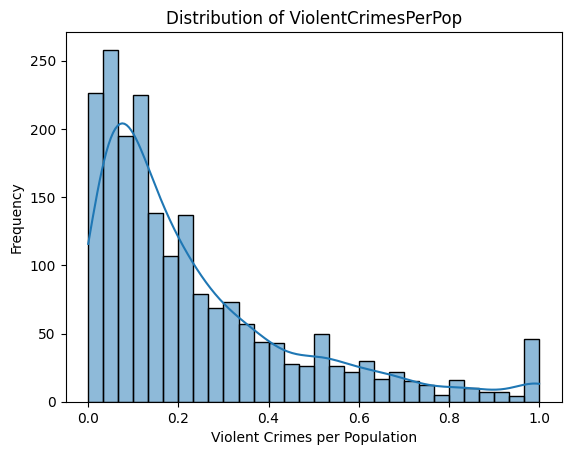

In [ ]:
sns.histplot(y, kde=True, bins=30)
plt.title("Distribution of ViolentCrimesPerPop")
plt.xlabel("Violent Crimes per Population")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Define the range of bins to test
bin_range = range(2, 11)  # Testing with 2 bins, 3 bins, ..., 10 bins
best_bins = None
best_accuracy = 0

for bins in bin_range:
    # Discretize the target variable into 'bins' number of bins
    discretizer = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='quantile')
    y2_binned = discretizer.fit_transform(y2.values.reshape(-1, 1)).ravel()  # Apply binning

    # Split the data into training and validation sets
    X2_train, X2_val, y2_train, y2_val = train_test_split(X2_encoded, y2_binned, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X2_train_scaled = scaler.fit_transform(X2_train)
    X2_val_scaled = scaler.transform(X2_val)

    # Train a Naive Bayes classifier
    nb_classifier = GaussianNB()
    nb_classifier.fit(X2_train_scaled, y2_train)

    # Predict and evaluate the model
    y2_pred = nb_classifier.predict(X2_val_scaled)

    # Calculate accuracy (you could also calculate other metrics like MSE or R2)
    accuracy = accuracy_score(y2_val, y2_pred)

    # If this accuracy is the best so far, save it
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_bins = bins

    print(f"Bins: {bins}, Accuracy: {accuracy}")

# Output the best number of bins
print(f"Best number of bins: {best_bins} with Accuracy: {best_accuracy}")


Bins: 2, Accuracy: 0.5488721804511278
Bins: 3, Accuracy: 0.39849624060150374
Bins: 4, Accuracy: 0.3308270676691729
Bins: 5, Accuracy: 0.20551378446115287
Bins: 6, Accuracy: 0.20551378446115287
Bins: 7, Accuracy: 0.13533834586466165
Bins: 8, Accuracy: 0.12781954887218044
Bins: 9, Accuracy: 0.11027568922305764
Bins: 10, Accuracy: 0.10776942355889724
Best number of bins: 2 with Accuracy: 0.5488721804511278


In [ ]:
discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')
y2_binned = discretizer.fit_transform(y2.values.reshape(-1, 1)).ravel()

# Step 3: Apply One-Hot Encoding to categorical features
X2_encoded = pd.get_dummies(X2)  # One-Hot Encoding for categorical variables

# Step 4: Split the data into training and validation sets (80-20 split)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_encoded, y2_binned, test_size=0.2, random_state=42)

# Check the dimensions of the splits (optional)
print(X2_train.shape, X2_val.shape, y2_train.shape, y2_val.shape)

# Step 5: Scale the feature data
scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)  # Fit and transform the training data
X2_val_scaled = scaler.transform(X2_val)  # Only transform the validation data

# Step 6: Train the Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X2_train_scaled, y2_train)

# Step 7: Predict the bins on the validation set
y2_pred_binned = nb_classifier.predict(X2_val_scaled)

# Step 8: Evaluate the model using classification report and confusion matrix
print("Classification Report:\n", classification_report(y2_val, y2_pred_binned))
print("Confusion Matrix:\n", confusion_matrix(y2_val, y2_pred_binned))

# Optionally, print accuracy score
accuracy = np.mean(y2_pred_binned == y2_val)
print(f"Accuracy: {accuracy}")

(1595, 1874) (399, 1874) (1595,) (399,)
Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      0.93      0.69       215
         1.0       0.56      0.10      0.17       184

    accuracy                           0.55       399
   macro avg       0.56      0.52      0.43       399
weighted avg       0.55      0.55      0.45       399

Confusion Matrix:
 [[201  14]
 [166  18]]
Accuracy: 0.5488721804511278
